## Age and Gender Detection System. 

### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [1]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset

In [3]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [5]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/kaggle/input/utkface-new/UTKFace/36_1_1_20170...,36,1
1,/kaggle/input/utkface-new/UTKFace/31_0_1_20170...,31,0
2,/kaggle/input/utkface-new/UTKFace/10_0_0_20170...,10,0
3,/kaggle/input/utkface-new/UTKFace/53_0_4_20170...,53,0
4,/kaggle/input/utkface-new/UTKFace/12_0_0_20170...,12,0


## Exploratory Data Anlysis

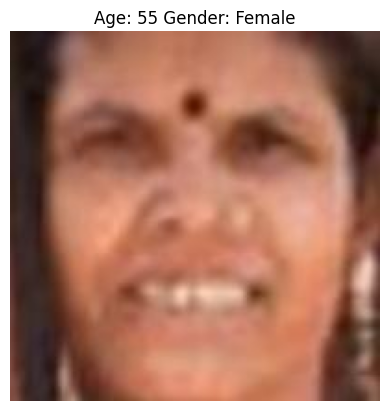

In [7]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

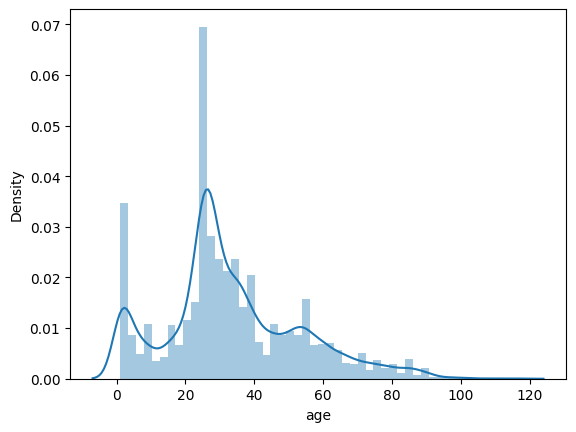

In [8]:
 # Age distribution
 sns.distplot(df['age'])

The distribution roughly follows a normal distribution that is slightly skewed to the right with a median of around 27 years. The range is from 0 to 120 years. There are some outliers at the higher end of the distribution.

<Axes: ylabel='count'>

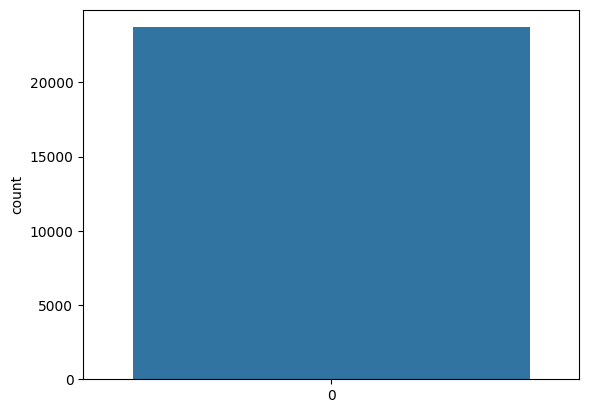

In [9]:
sns.countplot(df['gender'])

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

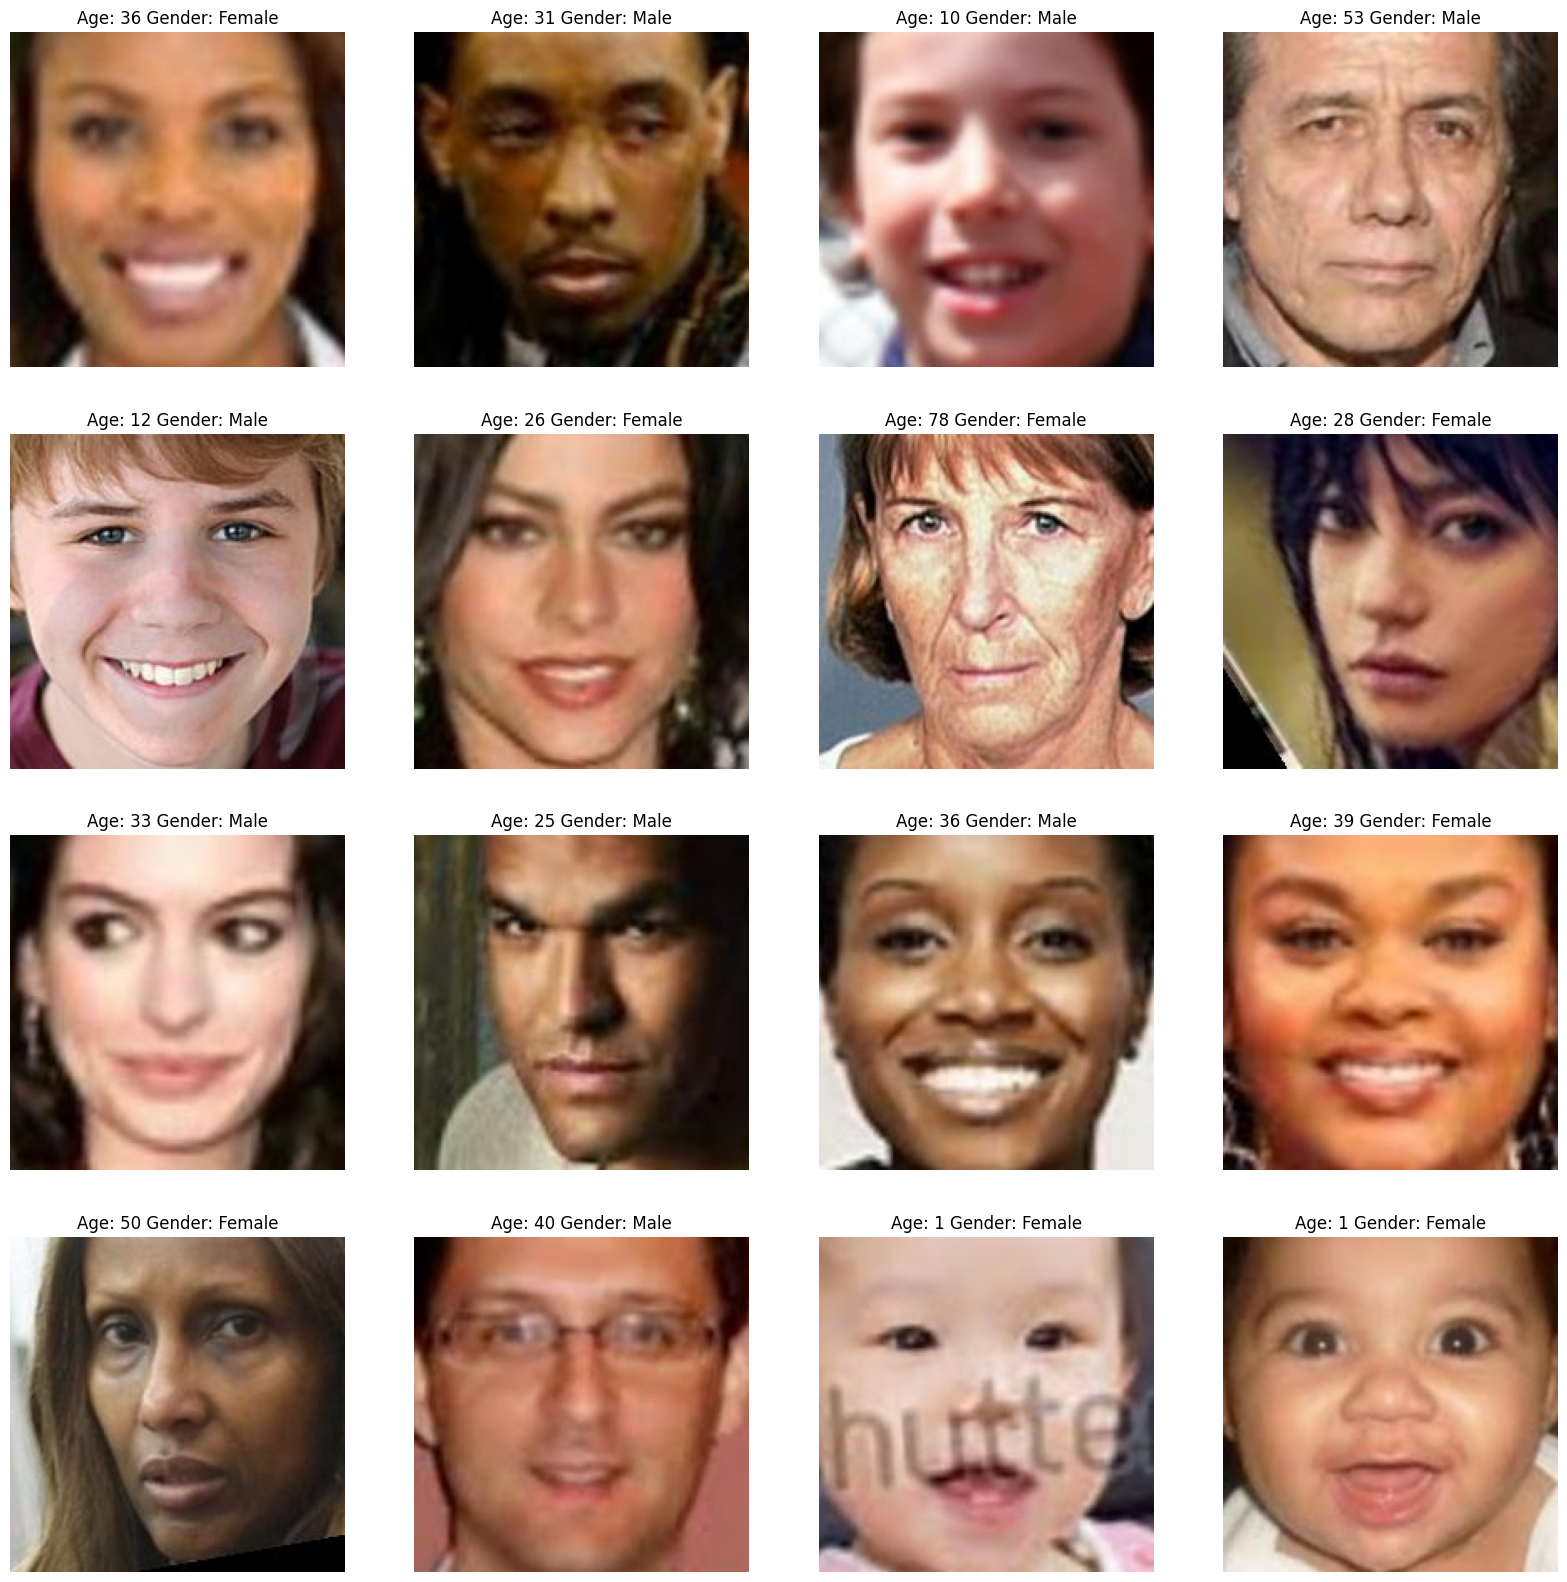

In [10]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

## Feature Extraction

In [11]:


def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        # Load image in grayscale
        img = load_img(image, color_mode='grayscale')
        # Resize using LANCZOS
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

# Call the function
X = extract_image_features(df['image_path'])


  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
X.shape

(23708, 128, 128, 1)

In [13]:
X = X / 255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

In [16]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

In [17]:
# plot the model
from tensorflow.keras.utils import plot_model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
warnings.filterwarnings("ignore")


# Reshape y_gender for binary classification
y_gender = y_gender.reshape(-1, 1)  # (23708, 1)

# Compile the model
model.compile(optimizer='adam',
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mean_squared_error'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})  # MAE for age

# Fit the model
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=150, validation_split=0.2)


Epoch 1/150


I0000 00:00:1727271350.212091     110 service.cc:145] XLA service 0x7d84ac002060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727271350.212153     110 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 16/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_mae: 26.7549 - gender_out_accuracy: 0.4799 - loss: 1116.9250

I0000 00:00:1727271356.151978     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - age_out_mae: 16.7024 - gender_out_accuracy: 0.5222 - loss: 478.4373 - val_age_out_mae: 12.6468 - val_gender_out_accuracy: 0.7379 - val_loss: 295.3527
Epoch 2/150
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 11.5165 - gender_out_accuracy: 0.7372 - loss: 231.1592 - val_age_out_mae: 9.1828 - val_gender_out_accuracy: 0.7794 - val_loss: 157.1550
Epoch 3/150
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 9.2735 - gender_out_accuracy: 0.7853 - loss: 156.0490 - val_age_out_mae: 7.7747 - val_gender_out_accuracy: 0.8123 - val_loss: 115.8565
Epoch 4/150
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_mae: 8.1563 - gender_out_accuracy: 0.8026 - loss: 120.2276 - val_age_out_mae: 7.7333 - val_gender_out_accuracy: 0.8349 - val_loss: 112.9637
Epoch 5/150
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - age_out_mae: 7.5652 - gender_out_accuracy: 0.8127 - loss: 105.4436 - val_age_out_mae: 7.9491 - val_gender_out_accuracy: 0.8473 - val_los

## Plot Results

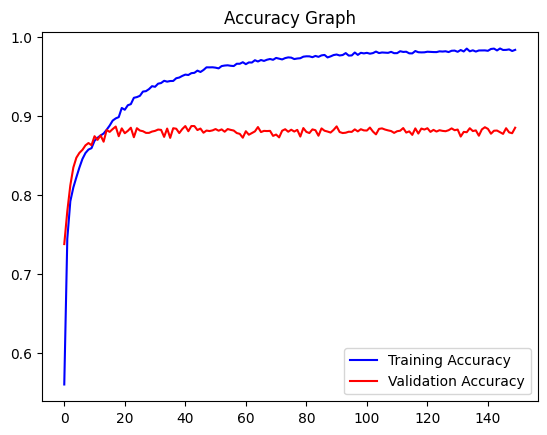

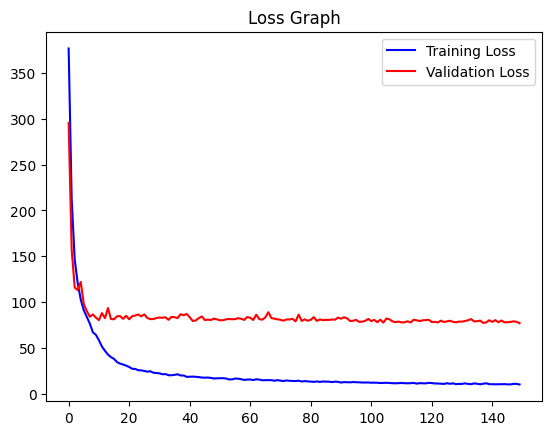

In [19]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

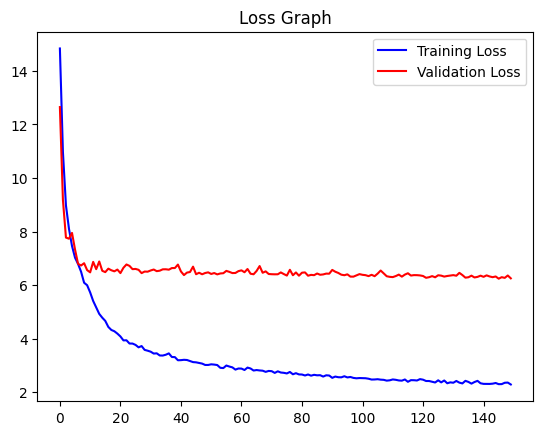

In [20]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Predicting Test Data

In [23]:
def get_image_features(image):
    # Load image in grayscale
    img = load_img(image, color_mode='grayscale')
    # Resize the image using LANCZOS for better quality
    img = img.resize((128, 128), Image.LANCZOS)
    # Convert the image to a numpy array
    img = np.array(img)
    # Reshape the image for the model input
    img = img.reshape(1, 128, 128, 1)
    # Normalize the image
    img = img / 255.0
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


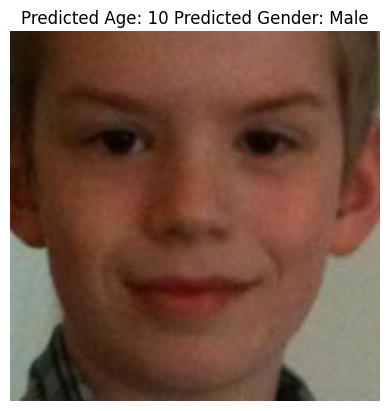

In [27]:
img_to_test = '/kaggle/input/utkface-new/crop_part1/10_0_0_20170110225518663.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))